In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import pickle
import os

In [2]:
from decoding_functions import *
from spot_detection_functions import *
from reading_data_functions import *

In [3]:
# data_path has to contain channel_info.csv, taglist.csv, tile_names.csv and selected_tiles directory with registered tif files
dataset_name = 'NT_ISS_KR0018'
data_path = '/Users/mg617/data/'+ dataset_name + '/' 

In [4]:
# read channel_info.csv and taglist.csv
barcodes_01, K, R, C, gene_names, channels_info = read_taglist_and_channel_info(data_path)

In [17]:
# input parameters for loading the tiles and for spot detection
tifs_path = data_path + 'selected_tiles/'
tile_names = read_csv(data_path + 'tile_names.csv')
tiles_info={'tile_size':1000, 'y_max':16, 'x_max':23, 'y_max_size':1000, 'x_max_size':1000, 'filename_prefix':'out_opt_flow_registered_'}
tiles_to_load = {'y_start':3, 'y_end':4, 'x_start':19, 'x_end':20} # select which tiles to load, including indices at the end
#tiles_to_load = {'y_start':0, 'y_end':tiles_info['y_max']-1, 'x_start':10, 'x_end':tiles_info['x_max']} # select which tiles to load, including indices at the end
spots_params = {'trackpy_diam_detect':5, 'trackpy_search_range':3, 'spot_diam_tophat':5} # parameters for spot detection
spots_params['trackpy_prc'] = 50 #by default this parameter is set to 64, decrease it to select more spots

In [18]:
# load tile by tile and extract spots in each using trackpy
spots, spots_loc, _ = load_tiles_to_extract_spots(tifs_path, channels_info, C, R, tile_names, tiles_info, tiles_to_load, spots_params)
#spots, spots_loc, _ = load_tiles_to_extract_spots(tifs_path, channels_info, C, R, tile_names, tiles_info, tiles_to_load, spots_params, anchor_available=False)
#spots, spots_loc, _ = load_tiles_to_extract_spots(tifs_path, channels_info, C, R, tile_names, tiles_info, tiles_to_load, spots_params, anchors_cy_ind_for_spot_detect=0, use_blob_detector=True)

Extracting spots from: X12_Y0 X13_Y0 X14_Y0 X15_Y0 X16_Y0 X17_Y0 X11_Y1 X12_Y1 X13_Y1 X14_Y1 X15_Y1 X16_Y1 X17_Y1 X18_Y1 X19_Y1 X10_Y2 X11_Y2 X12_Y2 X13_Y2 X14_Y2 X15_Y2 X16_Y2 X17_Y2 X18_Y2 X19_Y2 X20_Y2 X21_Y2 X10_Y3 X11_Y3 X12_Y3 X13_Y3 X14_Y3 X15_Y3 X16_Y3 X17_Y3 X18_Y3 X19_Y3 X20_Y3 X21_Y3 X22_Y3 X10_Y4 X11_Y4 X12_Y4 X13_Y4 X14_Y4 X15_Y4 X16_Y4 X17_Y4 X18_Y4 X19_Y4 X20_Y4 X21_Y4 X22_Y4 X11_Y5 X12_Y5 X13_Y5 X14_Y5 X15_Y5 X16_Y5 X17_Y5 X18_Y5 X19_Y5 X20_Y5 X21_Y5 X22_Y5 X23_Y5 X11_Y6 X12_Y6 X13_Y6 X14_Y6 X15_Y6 X16_Y6 X17_Y6 X18_Y6 X19_Y6 X20_Y6 X21_Y6 X22_Y6 X23_Y6 X11_Y7 X12_Y7 X13_Y7 X14_Y7 X15_Y7 X16_Y7 X17_Y7 X18_Y7 X19_Y7 X20_Y7 X21_Y7 X22_Y7 X23_Y7 X11_Y8 X12_Y8 X13_Y8 X14_Y8 X15_Y8 X16_Y8 X17_Y8 X18_Y8 X19_Y8 X20_Y8 X21_Y8 X22_Y8 X23_Y8 X11_Y9 X12_Y9 X13_Y9 X14_Y9 X15_Y9 X16_Y9 X17_Y9 X18_Y9 X19_Y9 X20_Y9 X21_Y9 X22_Y9 X12_Y10 X13_Y10 X14_Y10 X15_Y10 X16_Y10 X17_Y10 X18_Y10 X19_Y10 X20_Y10 X21_Y10 X22_Y10 X12_Y11 X13_Y11 X14_Y11 X15_Y11 X16_Y11 X17_Y11 X18_Y11 X19_Y11 X20_Y1

In [19]:
print('In total {} spots detected'.format(spots.shape[0]))

In total 170507 spots detected


In [35]:
# # # loading / saving already extracted spots 
# with open(data_path + 'decoding/extracted-spots/' + dataset_name + '_spots_trackpy_params.pickle', 'wb') as fp:
#      pickle.dump(spots_params, fp)
# np.save(data_path + 'decoding/extracted-spots/' + dataset_name + '_spots_trackpy50.npy', spots)
# np.save(data_path + 'decoding/extracted-spots/' + dataset_name + '_spots_notophat_trackpy50.npy', spots_notophat)
# spots_loc.to_csv(data_path + 'decoding/extracted-spots/' + dataset_name + '_spots_trackpy50_locations.csv', index=False)
# spots = np.load(data_path + 'decoding/extracted-spots/' + dataset_name + '_spots_trackpy.npy')
# spots_loc = read_csv(data_path + 'decoding/extracted-spots/' + dataset_name + '_spots_trackpy_locations.csv')

In [36]:
# estimate GMM parameters and compute class probabilities 
out = decoding_function(spots, barcodes_01, print_training_progress=True)
# creating a data frame from the decoding output
df_class_names = np.concatenate((gene_names,['infeasible','background','nan']))
df_class_codes = np.concatenate((channels_info['barcodes_AGCT'],['NA','0000','NA']))
decoded_spots_df = decoding_output_to_dataframe(out, df_class_names, df_class_codes)
decoded_df = pd.concat([decoded_spots_df, spots_loc], axis=1) 

100%|██████████| 60/60 [00:09<00:00,  6.12it/s]


The initial loss is 26.86738667620684 and the final loss is 15.765500829877952


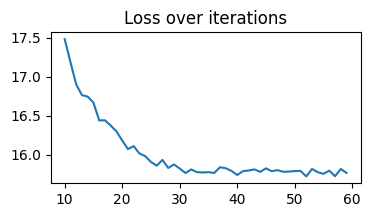

In [21]:
print('The initial loss is {} and the final loss is {}'.format(1/out['class_probs'].shape[0]*out['params']['losses'][0],1/out['class_probs'].shape[0]*out['params']['losses'][len(out['params']['losses'])-1]))
plt.figure(num=None, figsize=(4, 2), dpi=100, facecolor='w', edgecolor='k')
plt.plot(np.arange(10,len(out['params']['losses'])),(1/out['class_probs'].shape[0]*np.asarray(out['params']['losses'][10:])))
plt.title('Loss over iterations')
plt.show()

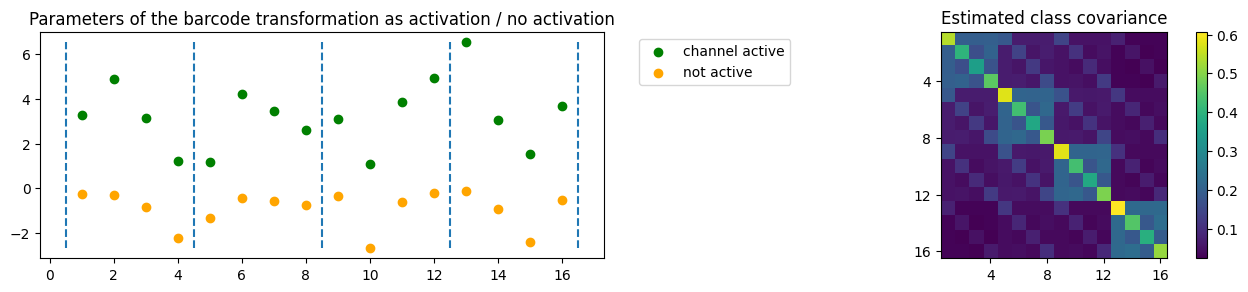

In [37]:
# plot estimated parameters for class means and covariance
plt.figure(num=None, figsize=(16, 3), dpi=100, facecolor='w', edgecolor='k')
activation = (out['params']['codes_tr_v_star']+out['params']['codes_tr_consts_v_star'])[0,:].numpy() #corresponding to the channel activation (code=1)
no_activation = out['params']['codes_tr_consts_v_star'][0,:].numpy() # (code=0)
channel_activation=np.stack((no_activation,activation))
plt.subplot(1, 2, 1)
plt.scatter(np.arange(1,1+R*C),activation,c='green') 
plt.scatter(np.arange(1,1+R*C),no_activation,c='orange') 
plt.legend(('channel active','not active'),bbox_to_anchor=(1.05, 1), loc='upper left')
plt.vlines(np.arange(0.5,R*C+.8,C), out['params']['codes_tr_consts_v_star'].min(), (out['params']['codes_tr_v_star']+out['params']['codes_tr_consts_v_star']).max(), linestyles='dashed')
plt.title('Parameters of the barcode transformation as activation / no activation')
plt.subplot(1, 2, 2)
plt.imshow(out['params']['sigma_star'])
plt.yticks(np.arange(3,R*C,4),np.arange(4, R*C+1, 4))
plt.xticks(np.arange(3,R*C,4),np.arange(4, R*C+1, 4))
plt.colorbar()
plt.title('Estimated class covariance')
#plt.savefig(os.getcwd() + '/out_imgs/' + dataset_name +'_params.png')
plt.show()

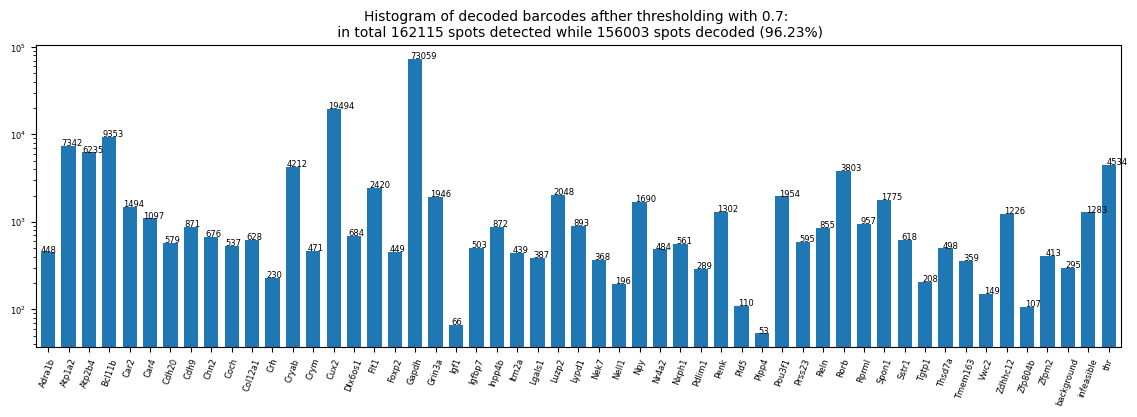

In [38]:
# plot a histogram of class assignments when class probabilities are thresholded by thr
thr=0.7
df = pd.concat([decoded_df.Name[decoded_df.Probability >thr].replace('perforin','Perforin').value_counts(), decoded_df.Name[decoded_df.Probability <=thr].replace(np.unique(decoded_df.Name),'thr').value_counts()]).sort_index(axis=0)
plt.figure(num=None, figsize=(14,4), dpi=100, facecolor='w', edgecolor='k')
ax = df.plot(kind='bar',width=0.7,rot=70,logy=True,fontsize=6,figsize=(14,4))
ax.set_facecolor('w')
num_decoded_barcodes = sum((decoded_df.Name!='background')&(decoded_df.Name!='infeasible')&(decoded_df.Name!='NaN')&(decoded_df.Probability>thr))
#ax.legend(["gmm: {} decoded spots with prob > {}".format(num_decoded_barcodes,thr)],fontsize=8)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),size=6) 
plt.title('Histogram of decoded barcodes afther thresholding with {}: \n in total {} spots detected while {} spots decoded ({}%)'.format(thr,decoded_df.shape[0], num_decoded_barcodes , np.round(100*num_decoded_barcodes/ decoded_df.shape[0], 2 )),fontsize=10)       
#plt.savefig(os.getcwd() + '/out_imgs/' + dataset_name +'_histogram.png')
plt.show()

In [13]:
print('Class names: {}'.format(np.unique(decoded_df.Name)))

Class names: ['Adra1b' 'Atp1a2' 'Atp2b4' 'Bcl11b' 'Car2' 'Car4' 'Cdh20' 'Cdh9' 'Chn2'
 'Coch' 'Col12a1' 'Crh' 'Cryab' 'Crym' 'Cux2' 'Dlx6os1' 'Flt1' 'Foxp2'
 'Gapdh' 'Grin3a' 'Igfbp7' 'Inpp4b' 'Itm2a' 'Lgals1' 'Luzp2' 'Lypd1'
 'Nek7' 'Nell1' 'Npy' 'Nr4a2' 'Nxph1' 'Pdlim1' 'Penk' 'Pld5' 'Plpp4'
 'Pou3f1' 'Prss23' 'Reln' 'Rorb' 'Rprml' 'Spon1' 'Sstr1' 'Tgtp1' 'Thsd7a'
 'Tmem163' 'Vwc2' 'Zdhhc12' 'Zfpm2' 'background' 'infeasible']


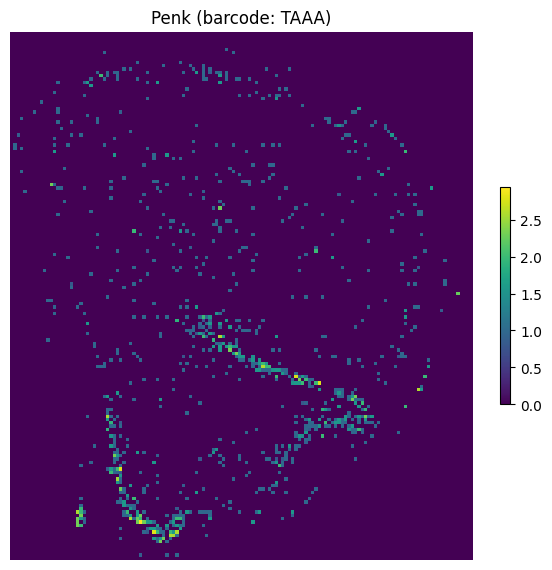

In [39]:
# plot any of the classes listed above
name = 'Cux2'
thr = 0.7
grid = 20
plot_probs = True
x_coord = np.floor(decoded_df.X[(decoded_df.Name == name) & (decoded_df.Probability >thr)].to_numpy(dtype=np.double)/grid).astype(np.int32)
y_coord = np.floor(decoded_df.Y[(decoded_df.Name == name) & (decoded_df.Probability >thr)].to_numpy(dtype=np.double)/grid).astype(np.int32)
D_gmm = np.zeros((int(np.ceil(decoded_df.Y.to_numpy(dtype=np.double).max()/grid)),int(np.ceil(decoded_df.X.to_numpy(dtype=np.double).max()/grid))))
if plot_probs:
    prob = decoded_df.Probability[decoded_df.Name == name].to_numpy(dtype=np.double)
    prob[prob<thr]=0
    for i in range(len(x_coord)):
        D_gmm[y_coord[i],x_coord[i]] = D_gmm[y_coord[i],x_coord[i]] + prob[i]
else:
    coords = np.concatenate((y_coord.reshape((len(x_coord),1)),x_coord.reshape((len(x_coord),1))), axis=1)
    coords_u ,coords_c = np.unique(coords ,axis=0, return_counts=True)
    D_gmm[coords_u[:,0],coords_u[:,1]]=coords_c
plt.figure(num=None, figsize=(7, 7), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(np.log2(1+D_gmm))
plt.axis('off')
plt.colorbar(fraction=0.02)
plt.title('{} (barcode: {})'.format(name,df_class_codes[df_class_names==name][0]))
#plt.savefig(os.getcwd() + '/out_imgs/' + dataset_name + '_decoded_' + name +'.png')
plt.show()

In [15]:
## save dataframe with decoded spots
#decoded_df.to_csv(data_path + 'decoding/' + dataset_name + '_GMMdecoding.csv', index=False)